In [13]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from tensorflow.keras import callbacks
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.metrics import accuracy_score, precision_score, recall_score
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [2]:
df = pd.read_csv("heart.csv")
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [3]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [33]:
df['target'].value_counts(normalize=True)

target
1    0.513171
0    0.486829
Name: proportion, dtype: float64

In [6]:
print(f"\nTrain size: {X_train.shape}, Test size: {X_test.shape}")


Train size: (820, 13), Test size: (205, 13)


In [34]:
categorical_cols = ['cp', 'restecg', 'slope', 'thal', 'sex', 'fbs', 'exang', 'ca']

In [35]:
numerical_cols = [col for col in df.columns if col not in categorical_cols + ['target']]

## Train-Test Split

In [36]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

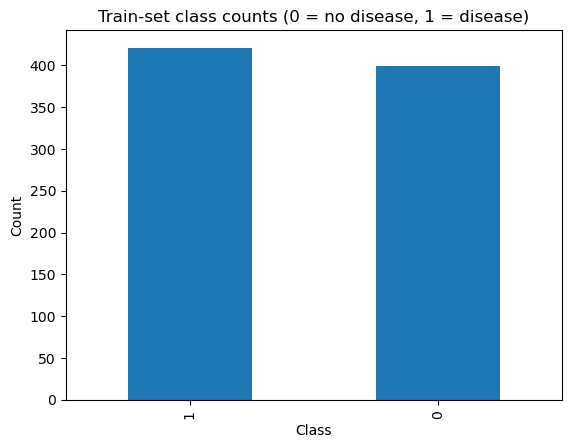

In [37]:
y_train.value_counts().plot(kind='bar')
plt.title("Train-set class counts (0 = no disease, 1 = disease)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Step 1 — Data check (output interpretation)

## Train/Test Shapes
- **Train:** `(820, 13)`  
- **Test:** `(205, 13)`  
- **Meaning:** 1,025 total rows split **80/20**. The `13` columns are **features** (the `target` column was removed from `X`).

## Class Balance (Train Set)
- Chart title: **“Train-set class counts (0 = no disease, 1 = disease)”**  
- Approximate counts:
  - **Class 1 (disease):** ~420
  - **Class 0 (no disease):** ~400
- **Meaning:** Classes are **roughly balanced**. Because we used **stratified** splitting, this ratio should reflect the full dataset.

## Why It Matters
- Near-balanced classes → **accuracy** is informative (we’ll still report **precision/recall**).
- Next steps will compare **raw vs MinMax vs Standard** feature scaling to see effects on **training loss**, **convergence speed**, and **metrics**.


In [38]:
def preprocess_data(X, scaler=None):
    ct = ColumnTransformer(transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', scaler, numerical_cols)
    ])
    X_transformed = ct.fit_transform(X)
    return X_transformed

# Preprocessing pipelines
X_train_raw = pd.get_dummies(X_train)  # Raw: One-hot encode only
X_test_raw = pd.get_dummies(X_test)

X_train_norm = preprocess_data(X_train, MinMaxScaler())
X_test_norm = preprocess_data(X_test, MinMaxScaler())

X_train_std = preprocess_data(X_train, StandardScaler())
X_test_std = preprocess_data(X_test, StandardScaler())

## Neural Network Model

In [39]:
def build_compile_model(input_dim, learning_rate=0.001):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

## Train Models – Raw vs Normalized vs Standardized

In [42]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
def train_and_evaluate(X_train, X_test, y_train, y_test, variant_name):
    model = build_compile_model(X_train.shape[1])
    es = EarlyStopping(patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train,
                        validation_split=0.1,
                        epochs=100,
                        batch_size=32,
                        callbacks=[es],
                        verbose=0)
    
    # Evaluate
    y_pred = (model.predict(X_test) > 0.5).astype('int32')
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    print(f"\n--- {variant_name} ---")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")
    
    return history

history_raw = train_and_evaluate(X_train_raw, X_test_raw, y_train, y_test, "Raw")
history_norm = train_and_evaluate(X_train_norm, X_test_norm, y_train, y_test, "Normalized (MinMax)")
history_std = train_and_evaluate(X_train_std, X_test_std, y_train, y_test, "Standardized (StandardScaler)")

C:\Users\bbuser\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 

--- Raw ---
Accuracy: 0.8146, Precision: 0.7597, Recall: 0.9333


C:\Users\bbuser\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step 

--- Normalized (MinMax) ---
Accuracy: 0.9805, Precision: 0.9810, Recall: 0.9810


C:\Users\bbuser\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step 

--- Standardized (StandardScaler) ---
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


## Plot Loss Curves

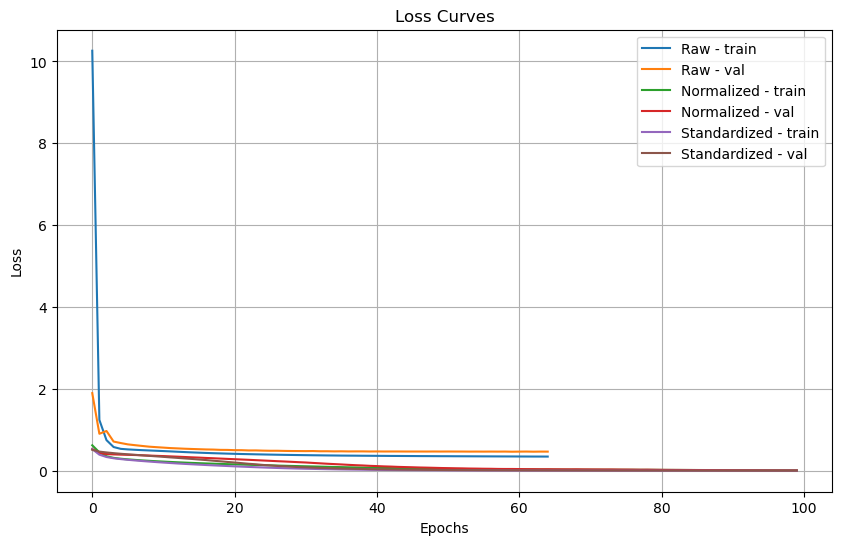

In [43]:
def plot_history(history, label):
    plt.plot(history.history['loss'], label=f"{label} - train")
    plt.plot(history.history['val_loss'], label=f"{label} - val")

plt.figure(figsize=(10, 6))
plot_history(history_raw, "Raw")
plot_history(history_norm, "Normalized")
plot_history(history_std, "Standardized")
plt.title("Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

## Learning Rate Sensitivity Test

In [44]:
for lr in [0.01, 0.001, 0.0001]:
    print(f"\nTesting with learning rate = {lr}")
    _ = train_and_evaluate(X_train_std, X_test_std, y_train, y_test, f"Standardized - LR={lr}")


Testing with learning rate = 0.01


C:\Users\bbuser\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step 

--- Standardized - LR=0.01 ---
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000

Testing with learning rate = 0.001


C:\Users\bbuser\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step 

--- Standardized - LR=0.001 ---
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000

Testing with learning rate = 0.0001


C:\Users\bbuser\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step 

--- Standardized - LR=0.0001 ---
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000
